In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#ROOT_DIR = "content"
ROOT_DIR = "/content" # Colab일경우
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "brain_tumor")
TRAIN_DATA_ROOT_DIR = os.path.join("/content/brain_tumor/Training")
TEST_DATA_ROOT_DIR = os.path.join("/content/brain_tumor/Testing")

In [3]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive/acorn", "archive_shuffle.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "archive_shuffle.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

Mounted at /content/gdrive/


['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
test label : no_tumor  =>  317
test label : glioma_tumor  =>  741
test label : meningioma_tumor  =>  750
test label : pituitary_tumor  =>  721
['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
test label : no_tumor  =>  79
test label : glioma_tumor  =>  185
test label : meningioma_tumor  =>  187
test label : pituitary_tumor  =>  180
Found 2529 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4
(4, 224, 224, 3) (4,)
[0. 3. 1. 0.]
17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)      

[0.12982496619224548, 0.9603803753852844]

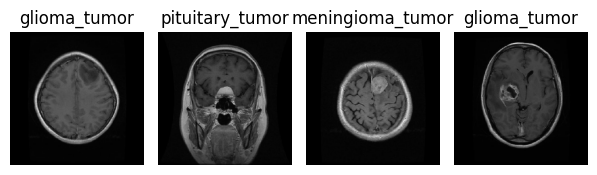

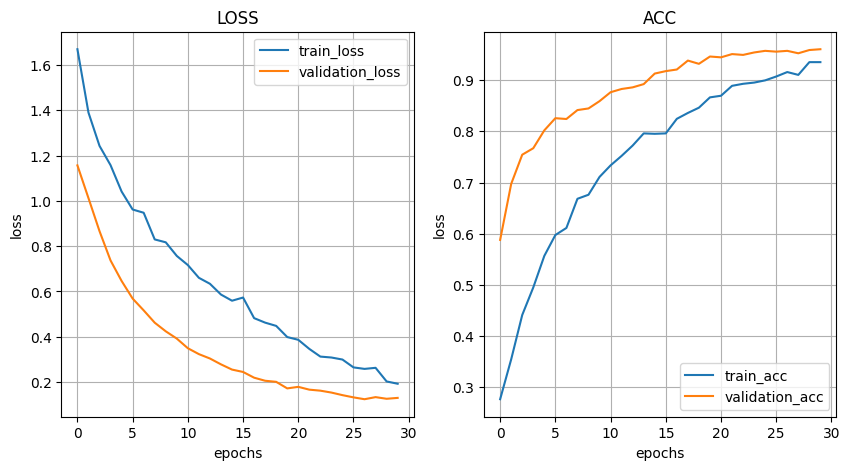

In [4]:
##### 훈련 데이터
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

## Image Shape 설정

IMG_WIDTH = 224 # colab에서 224로 설정
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=4, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=4, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

## 32장의 이미지 확인

## ImageDataGenerator를 통해 전달된 이미지 출력

data, label = train_generator.next()

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'glioma_tumor', 1: 'meningioma_tumor', 2 : 'no_tumor', 3 : 'pituitary_tumor'}
4

for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

## Fine Tunning을 위한 pre-trained 정의 및 모델 구축

# 가중치 imagenet으로 설정
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D()) # Flatten() 대신 사용가능

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))


# 4 대신 정답갯수를 알 수 있었던 train_generator.num_classes
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-5), metrics=["acc"])

start_time = datetime.now()

result = model.fit(train_generator, epochs=30, validation_data=test_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

model.evaluate(test_generator)